In [15]:
# copied directly from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial

from io import open
import glob
import os


def findFiles(path):
    return glob.glob(path)


print(findFiles("data/names/*.txt"))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s) -> str:
    return "".join(
        c
        for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn" and c in all_letters
    )


print(unicodeToAscii("Ślusàrski"))

# Build the category_lines dictionary, a list of names per language
category_lines : dict[str, list[str]] = {}
all_categories = []


# Read a file and split into lines
def readLines(filename) -> list[str]:
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]


for filename in findFiles("data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [16]:
print(f"there are {n_categories} different languages")
print(all_categories[:5])
print(category_lines['Vietnamese'][:5])

there are 18 different languages
['Czech', 'German', 'Arabic', 'Japanese', 'Chinese']
['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']


In [27]:
import torch


# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


letter_tensor = letterToTensor("J")
print(letter_tensor.shape)
print(letter_tensor)

print("~~the following tensor represents the word Jones~~")
print(lineToTensor("Jones").size())
print(lineToTensor("Jones"))

torch.Size([1, 57])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
~~the following tensor represents the word Jones~~
torch.Size([5, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0.

In [18]:
print(n_letters)

57


In [19]:
import torch.nn as nn
import torch.nn.functional as F


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
# n_letters = 57
# n_categories = # of different languages
rnn = RNN(n_letters, n_hidden, n_categories)

In [20]:
input = letterToTensor("A")
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9165, -2.9395, -2.9302, -2.8363, -2.8561, -2.9529, -2.8949, -2.9349,
         -2.9296, -2.8957, -2.8788, -2.7755, -2.9806, -2.8935, -2.9542, -2.8690,
         -2.7917, -2.8251]], grad_fn=<LogSoftmaxBackward0>)


In [21]:
input = lineToTensor("Albert")
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9165, -2.9395, -2.9302, -2.8363, -2.8561, -2.9529, -2.8949, -2.9349,
         -2.9296, -2.8957, -2.8788, -2.7755, -2.9806, -2.8935, -2.9542, -2.8690,
         -2.7917, -2.8251]], grad_fn=<LogSoftmaxBackward0>)


In [22]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


print(categoryFromOutput(output))

('Greek', 11)


In [24]:
import random


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print("category =", category, "/ line =", line)
    print(f"catogery tensor: {category_tensor}")

category = German / line = Bosch
catogery tensor: tensor([1])
category = French / line = Paquet
catogery tensor: tensor([7])
category = Polish / line = Rudawski
catogery tensor: tensor([17])
category = Korean / line = Kwang 
catogery tensor: tensor([16])
category = Spanish / line = Abello
catogery tensor: tensor([10])
category = Portuguese / line = Lobo
catogery tensor: tensor([13])
category = Japanese / line = Yoshimatsu
catogery tensor: tensor([3])
category = Russian / line = Awerintsev
catogery tensor: tensor([6])
category = Czech / line = Kubin
catogery tensor: tensor([0])
category = Scottish / line = Williamson
catogery tensor: tensor([14])


In [28]:
criterion = nn.NLLLoss()

In [31]:
learning_rate = (
    0.005  # If you set this too high, it might explode. If too low, it might not learn
)


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        #print(line_tensor[i].size())
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    # performing a manual gradient descent update on the parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

### Training ###

In [32]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = "✓" if guess == category else "✗ (%s)" % category
        print(
            "%d %d%% (%s) %.4f %s / %s %s"
            % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct)
        )

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 1.4849 Harb / Arabic ✓
10000 10% (0m 8s) 0.2161 Sakelaris / Greek ✓
15000 15% (0m 12s) 0.0274 Batsakis / Greek ✓
20000 20% (0m 16s) 2.5099 Courtemanche / Scottish ✗ (French)
25000 25% (0m 20s) 0.1796 Bukowski / Polish ✓
30000 30% (0m 23s) 1.4912 Santos / Greek ✗ (Portuguese)
35000 35% (0m 27s) 1.2475 Salcedo / Portuguese ✗ (Spanish)
40000 40% (0m 31s) 0.6285 Diev / Russian ✓
45000 45% (0m 35s) 0.0515 Africano / Italian ✓
50000 50% (0m 39s) 3.6110 Castillion / English ✗ (Spanish)
55000 55% (0m 44s) 0.1319 Sunada / Japanese ✓
60000 60% (0m 49s) 2.6966 Matocha / Portuguese ✗ (Czech)
65000 65% (0m 53s) 0.8797 Buren / German ✗ (Dutch)
70000 70% (0m 57s) 0.3440 Inaba / Japanese ✓
75000 75% (1m 1s) 0.6266 Santiago / Portuguese ✓
80000 80% (1m 5s) 0.5437 Gutierrez / Spanish ✓
85000 85% (1m 9s) 0.7590 Sung / Chinese ✗ (Korean)
90000 90% (1m 13s) 0.9220 Hall / English ✓
95000 95% (1m 17s) 0.0190 Polites / Greek ✓
100000 100% (1m 20s) 0.2246 Said / Arabic ✓


### Graph loss ###

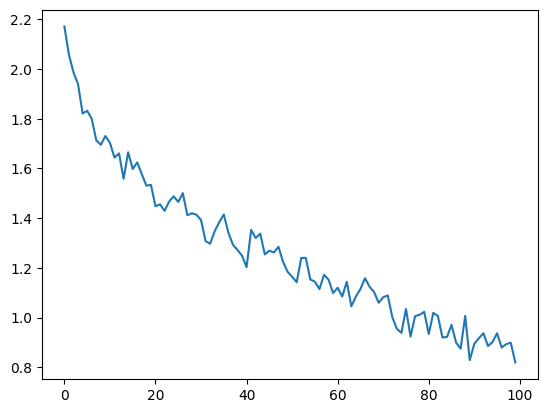

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluating the Results ###

/var/folders/qh/rrvm0zvs2jg1wtj1pwtyd71m0000gn/T/ipykernel_17365/2887250372.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + all_categories, rotation=90)
/var/folders/qh/rrvm0zvs2jg1wtj1pwtyd71m0000gn/T/ipykernel_17365/2887250372.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + all_categories)


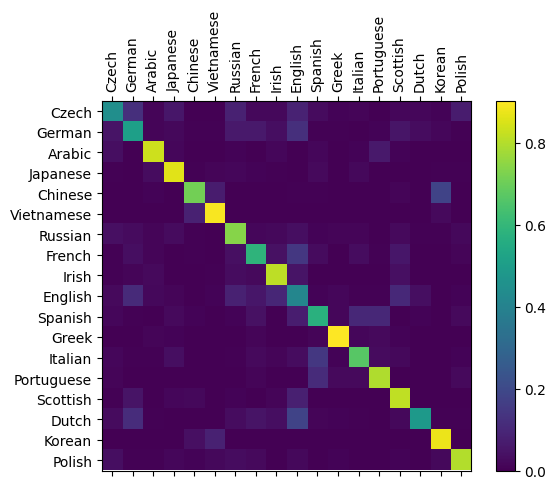

In [34]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([""] + all_categories, rotation=90)
ax.set_yticklabels([""] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Test on some inputs

In [40]:
def predict(input_line, n_predictions=3):
    print("\n> %s" % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print("(%.2f) %s" % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


predict("Dovesky")
predict("Jackson")
predict("Satoshi")
predict("Jae")


> Dovesky
(-0.14) Russian
(-2.77) Czech
(-3.02) English

> Jackson
(-0.33) Scottish
(-1.58) English
(-3.30) Russian

> Satoshi
(-0.54) Polish
(-1.46) Japanese
(-2.92) Czech

> Jae
(-0.04) Chinese
(-4.63) Korean
(-4.89) French
